## 3. Creating gridded ELM inputs
This notebook demonstrates how to sample raw ERA5-Land hourly meteorological data from Google Earth Engine using either points or polygons, then process the downloaded data for export to ELM-ready gridded netCDF files.

While there are essentially still only two functions you must call to download and export ELM--ready data, because we're now exporting these data as gridded (or at least spatially-distributed) netCDF files, the inputs are slightly more complicated. Notebook `2` is what you want to use if you only need site netCDFs (it can do more than one site at a time, but the exporting is done per site.)
  
In this notebook, we will consider the watershed of the streamflow gage near the outlet of the Kuparak River. Our goal will be to sample ERA5-Land hourly data at the native ERA5 resolution for all grid cells that intersect this watershed. It is OK not to have rectangular domains when providing ELM met data, as ELM searches for the nearest point in the netCDF to extract its met data. Therefore, you can have any sets of latitutdes and longitudes. That's what we'll do here to avoid fetching and reformatting ERA5-Land hourly data that we don't need. It mostly happens under the hood, anyway. :) 

https://drive.google.com/drive/folders/1tKCroPzeaTT0K6SEbl9YtQtkuZYs90Gq?usp=sharing

![kuparak_gageshed](https://github.com/NGEE-Arctic/NGEEGEE/raw/main/notebooks/notebook_data/images/3-kuparak-conv2.jpg)

X:\Research\NGEE Arctic\NGEEGEE



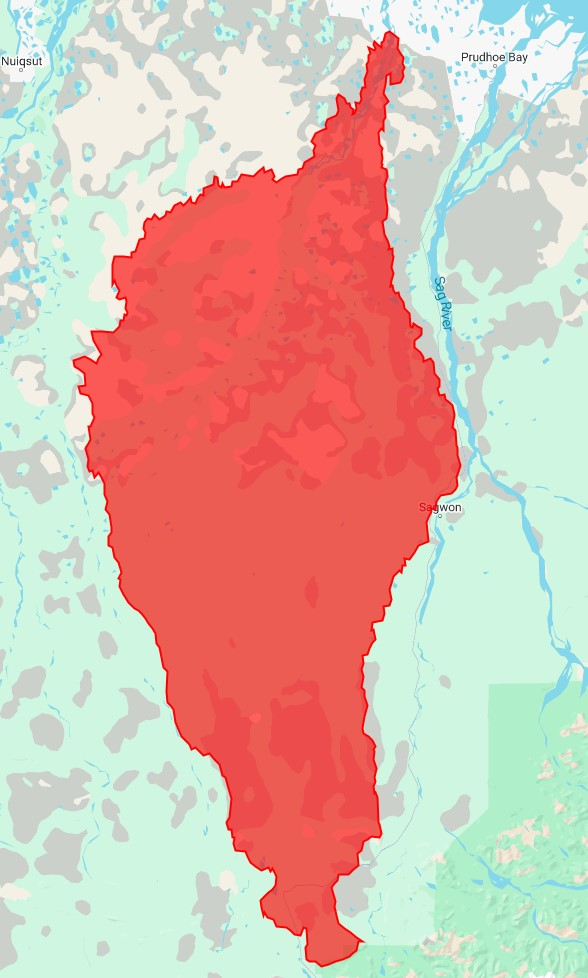

In [2]:
from IPython.display import HTML
import base64
from ngeegee.utils import _ROOT_DIR
from pathlib import Path

print(_ROOT_DIR)
image_path = _ROOT_DIR / 'notebooks' / 'notebook_data' / 'images' / '3-kuparak-conv2.jpg'
# # Read the image and convert it to Base64
with open(image_path, 'rb') as f:
    img_data = f.read()
    img_base64 = base64.b64encode(img_data).decode('utf-8')


html_img = f'<img src="data:image/jpeg;base64,{img_base64}" alt="kuparak_gageshed" />'
display(HTML(html_img))


In [1]:
import ee
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely import Polygon
from ngeegee import utils
from ngeegee import metadata as md
from ngeegee import e5l_utils as eu

# Make sure to Initialize with the correct project name (do not use mine--it won't work for you)
ee.Initialize(project='ee-jonschwenk')

# Build our points dictionary
points = {'abisko' : (68.35, 18.78333),
        'tvc' : (68.742, -133.499),
        'toolik' : (68.62758, -149.59429),
        'chars' :  (69.1300, -105.0415),
        'qhi' : (69.5795, -139.0762),
        'sam' : (72.22, 126.3),
        'sjb' : (78.92163, 11.83109)}

# Create 1x1 degree box geometries around each point
geometries = []
pids = []

for pid, (lat, lon) in points.items():
    # Create a 1x1 degree box centered on (lat, lon)
    half_size = 0.5  # Half-degree to make a 1x1 box
    box = Polygon([
        (lon - half_size, lat - half_size),  # Bottom-left
        (lon + half_size, lat - half_size),  # Bottom-right
        (lon + half_size, lat + half_size),  # Top-right
        (lon - half_size, lat + half_size),  # Top-left
        (lon - half_size, lat - half_size)   # Closing point
    ])
    geometries.append(box)
    pids.append(pid)

# Create a GeoDataFrame - note that it must have a column called "gid" that provides a string ID for each geometry 
gdf = gpd.GeoDataFrame({'gid': pids, 'geometry': geometries}, crs="EPSG:4326")


### Set up our request via a dictionary of parameters
We have a few more parameter choices now than we had in `1a`, and some more conveniences. 

First, we still need to provide the specific ERA5-Land hourly bands we want to sample. If you just want the ELM-required bands, there is now a convenient method to request just those: `elm`. You can see the `elm_required_bands` with the following:

In [2]:
print(md.elm_data_dicts()['elm_required_bands'])

['temperature_2m', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_solar_radiation_downwards_hourly', 'surface_thermal_radiation_downwards_hourly', 'total_precipitation_hourly', 'surface_pressure', 'dewpoint_temperature_2m']


Second, we can now specify a `gee_scale`. This is the resolution in meters over which GEE should sample the base ERA5-Land hourly data at to perform spatial averaging. You can specify `native` to use the ERA5-Land hourly's native resolution of ~11km, but if you're running bigger polygons, you might want to choose a coarser scale. See [this documentation](https://developers.google.com/earth-engine/guides/scale#:~:text=The%20lowest%20level%20of%20the,within%20a%20256x256%20pixel%20tile.) if you have questions about scale implications. We'll just stick with `native` for this test.

Third, we have a parameter that adjusts how big our batch size should be. This parameter is called `gee_years_per_task`, and refers to how many ERA5-Land hourly years each Task sent to GEE should cover. In general, the more geometries you are sampling, the lower you want this number to be. The default of 5 should work OK for a few hundred geometries, but if you're doing thousands of geometries you might want to lower it to 1 or 2. Note that there is an optimal number for this parameter in terms of speed of output, but it's basically unknowable. On your end, tt depends on the size of your job (number of geometries and length of time you sample). On the GEE end (unknowable exactly), it depends on current server loads, task prioritization, and memory constraints. **In general, it is better to run more, smaller Tasks on GEE as opposed to larger, fewer ones.** We will set it to 2 in this example to prove that post-processing batching works just fine :) 

Fourth, we already constructed `gdf` which contains our polygons to sample. We will feed this directly as part of our `params` dictionary. **However**, if you have many polygons, or if they have lots of vertices, this method will fail as there is a size limit on geometries that you're able to pass directly from the Python API to GEE. Instead, you will need to upload your shapefile to GEE as an Asset. This is very easy to do; see [this documentation](https://developers.google.com/earth-engine/guides/manage_assets#code-editor_1). Once you've uploaded it, you can now just provide a string to this parameter that represents the path to the asset--for example, `'projects/ee-jonschwenk/assets/AK_temp_20230530'`. Again, here we will just use our gdf. **Remember that your geometries must have a `gid` field containing unique identifiers for each geometry feature.** 

Ok, now we can build our `params` dictionary and spin up some Tasks.

In [ ]:
params = {
    "start_date" : "2018-01-01", # 1950-01-01 is the earliest possible; for speed we just sample a couple years here
    "end_date" : "2100-01-01", # If your end date is longer than what's available, it will just truncate at the last available date. Here I've used the year 2100 to ensure we download all data.
    "geometries" : gdf, # Either a GeoDataFrame with Point or Polygon geometries, or a string that is the path to a preloaded GEE asset. Either way, must have a 'gid' column.
    "gee_bands" : 'elm', # You can also specify 'all' to get all bands/variables, or provide a list of variables (e.g. ['temperature_2m', 'total_evaporation_hourly', 'soil_temperature_level_1'])
    "gee_years_per_task" : 2,
    "gee_scale" : 'native', # Can also choose a number in meters. For ERA5-Land hourly data, it does no good to specify anything < 11000 as that's the native scale of the data 
    "job_name" : "ngee_test_polygons_batching",  # Output CSV file name
    "gdrive_folder" : "ngee_test_2",  # Google Drive folder name - will be created if it doesn't exist
}

# Send the Tasks to GEE! This takes a little while as some time metadata is fetched using getInfo().
eu.sample_e5lh(params)

Your request will be executed as 4 Tasks in Google Earth Engine.
Export task submitted: ngee_test_polygons_batching_2018-01-01_2020-01-01
Export task submitted: ngee_test_polygons_batching_2020-01-01_2022-01-01
Export task submitted: ngee_test_polygons_batching_2022-01-01_2024-01-01
Export task submitted: ngee_test_polygons_batching_2024-01-01_2025-02-22


'All export tasks started. Check Google Drive or Task Status in the Javascript Editor for completion.'

### Now we wait.
You've sent some Tasks to Google Earth Engine. You can check on their state using the [GEE Javascript code editor](http://code.earthengine.google.com) by clicking the `Tasks` tab in the upper-right panel. Eventually it will finish, and your csv will show up where you told GEE to put it: `gdrive_folder/`.

The amount of time you wait totally depends on your job size and GEE's current load. I am able to have 4 Tasks running at once on GEE--any more and they wait for one of the 4 to finish first. GEE controls these things. In general, unless you're running something enormous, it shouldn't take more than a few hours, and can take as little as a few minutes. Also note that the time of day may impact the runtimes, as GEE servers get hit more during 9-5 USA. I ran the above on Saturday and it took 6 minutes to finish all 4 Tasks.

**Important!** Once all Tasks are complete, you must move all the files from your GDrive to a local directory on your machine. Make sure there is nothing else in this folder besides all the files that were exported from this Job. The easiest and fastest way to move files from GDrive to local is with the Google Drive app, but you can also just download from the browser (it's annoying this way because GDrive wants to zip everything which can take awhile if you have lots of files).

## Exporting to ELM-ready format
At this point, you should have a local directory with all the `csv` files exported from your GEE Tasks. This local directory should have no other files in it besides these.

We need to define two directories for this next step. One is what is mentioned above--where to find the `csv` files. The other is where we want the exported ELM-ready netCDFs to go.

We also need to provide the `lon` and `lat` for each Polygon (or Point). This is a bit awkward right now and will probably eventually be changed, but for now we just make a DataFrame that links each `pid` to a `lat` and `lon`.

In [ ]:
csv_directory = utils._DATA_DIR / 'batchtesting' # where I've put my .csv files
write_directory = csv_directory / 'elm_formatted' # where I want my ELM-formatted netCDFs to go

# Provides the latitude and longitude for each Polygon's or Point's gid
# Here we're just using the center of each Polygon
df_loc = pd.DataFrame({'gid' : points.keys(),
                    'lat' : [points[p][0] for p in points],
                    'lon' : [points[p][1] for p in points]}) 

eu.e5hl_to_elm(csv_directory, write_directory, df_loc, remove_leap=True) # We will also remove leap days


## And you're done!
Look at your `write_directory`. There should be 7 directories, each named the `gid` we specified for our geometries ('abisko', 'chars', 'qhi', 'sam', 'sjb', 'toolik', 'tvc').

And in each of those directories, you should have 7 netCDF files--one for each ELM-required variable. Note that these are following the *coupler bypass* standard set by Dan Riscutto in OLMT. Future development of this repo will allow `DATM_MODE` if it's ever needed. The variables and their required formatting/compression are slightly different between the two.

## Important! 
I have not yet implemented proper compression for the ELM-ready variables. Probably means that as-is, they won't work. This will be fixed in the future.